# American hand sign classification
Sign language is one of the oldest and most natural forms of language for communication, but since most people do not know sign language and
interpreters are very difficult to come by => neural networks for ASL alphabet classification.

## Setup

### Dependencies

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.image import imread

from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import  LabelBinarizer
from tensorflow.keras.utils import img_to_array, array_to_img

from PIL import Image
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, LeakyReLU

### Mount GoogleDrive for data

In [2]:
## this is Colab-specific; remove if you are not using Colab
## connect drive as data source
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
## set data directory
base_dir = '/content/drive/MyDrive/'
data_dir = base_dir + 'datasets/asl_dataset'

### Check if data is available

Data gets read from connected google drive

In [10]:
for dirname, _, filenames in os.walk(data_dir + ''):
  for filename in filenames:
    print(os.path.join(dirname, filename))

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
/content/drive/MyDrive/datasets/asl_dataset/g/hand1_g_right_seg_2_cropped.jpeg
/content/drive/MyDrive/datasets/asl_dataset/g/hand2_g_bot_seg_5_cropped.jpeg
/content/drive/MyDrive/datasets/asl_dataset/g/hand2_g_right_seg_5_cropped.jpeg
/content/drive/MyDrive/datasets/asl_dataset/g/hand2_g_dif_seg_5_cropped.jpeg
/content/drive/MyDrive/datasets/asl_dataset/g/hand1_g_top_seg_5_cropped.jpeg
/content/drive/MyDrive/datasets/asl_dataset/g/hand3_g_dif_seg_4_cropped.jpeg
/content/drive/MyDrive/datasets/asl_dataset/g/hand2_g_dif_seg_1_cropped.jpeg
/content/drive/MyDrive/datasets/asl_dataset/g/hand2_g_left_seg_2_cropped.jpeg
/content/drive/MyDrive/datasets/asl_dataset/g/hand5_g_bot_seg_4_cropped.jpeg
/content/drive/MyDrive/datasets/asl_dataset/g/hand1_g_top_seg_3_cropped.jpeg
/content/drive/MyDrive/datasets/asl_dataset/g/hand1_g_bot_seg_2_cropped.jpeg
/content/drive/MyDrive/datasets/asl_dataset/g/hand1_g_dif_seg_1_cropped.jpeg
/con

## Data analysis

### Printing all available target classes:

In [11]:
from os import listdir
total_signs=sorted(listdir(data_dir + "/asl_dataset"))
print(total_signs)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


### Plotting some images to get better understanding

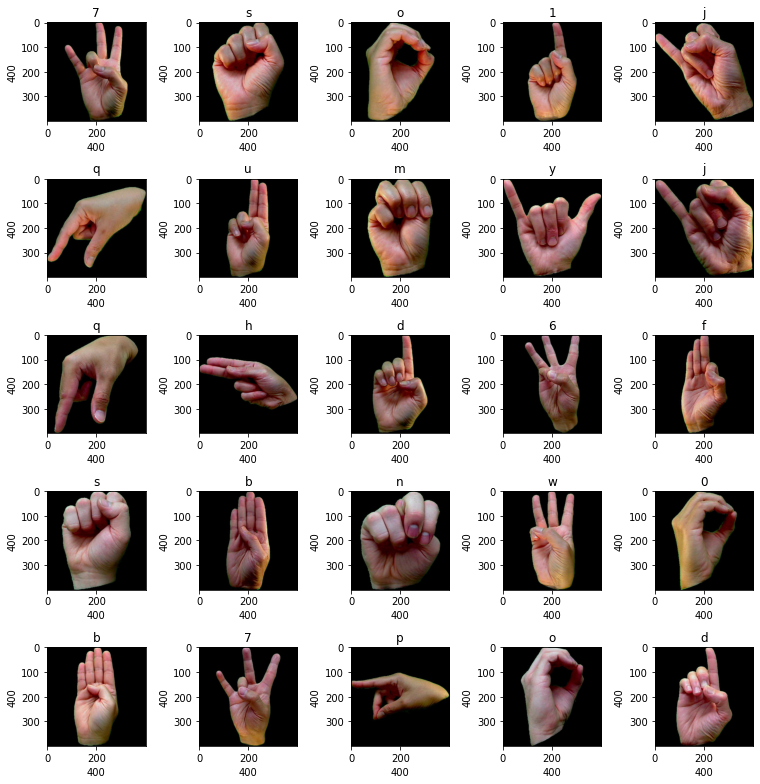

In [13]:
plt.figure(figsize=(11, 11))
path = data_dir
for i in range(1, 26):
  plt.subplot(5, 5, i)
  plt.tight_layout()
  directry=random.choice(total_signs)
  rand_img = imread(path + '/' + directry + '/' + random.choice(sorted(listdir(path+'/'+directry+'/'))))
  plt.imshow(rand_img)
  plt.title(directry)
  plt.xlabel(rand_img.shape[1], fontsize = 10)
  plt.ylabel(rand_img.shape[0], fontsize = 10)

### Check available data

In [14]:
for sign in total_signs:
  print(pd.value_counts(data_dir + "/asl_dataset/" + sign))

/content/drive/MyDrive/datasets/asl_dataset/asl_dataset/0    57
dtype: int64
/content/drive/MyDrive/datasets/asl_dataset/asl_dataset/1    57
dtype: int64
/content/drive/MyDrive/datasets/asl_dataset/asl_dataset/2    57
dtype: int64
/content/drive/MyDrive/datasets/asl_dataset/asl_dataset/3    57
dtype: int64
/content/drive/MyDrive/datasets/asl_dataset/asl_dataset/4    57
dtype: int64
/content/drive/MyDrive/datasets/asl_dataset/asl_dataset/5    57
dtype: int64
/content/drive/MyDrive/datasets/asl_dataset/asl_dataset/6    57
dtype: int64
/content/drive/MyDrive/datasets/asl_dataset/asl_dataset/7    57
dtype: int64
/content/drive/MyDrive/datasets/asl_dataset/asl_dataset/8    57
dtype: int64
/content/drive/MyDrive/datasets/asl_dataset/asl_dataset/9    57
dtype: int64
/content/drive/MyDrive/datasets/asl_dataset/asl_dataset/a    57
dtype: int64
/content/drive/MyDrive/datasets/asl_dataset/asl_dataset/b    57
dtype: int64
/content/drive/MyDrive/datasets/asl_dataset/asl_dataset/c    57
dtype: int64

In [18]:
dir1 = data_dir + "/asl_dataset/"
root_dir = listdir(dir1)
image_list, label_list = [], []
root_dir

['9',
 'u',
 'r',
 'i',
 't',
 '8',
 '0',
 '6',
 'z',
 '1',
 'g',
 '7',
 'n',
 's',
 'a',
 'v',
 'h',
 'c',
 'j',
 'd',
 'm',
 'f',
 'o',
 '3',
 'q',
 'k',
 'y',
 '4',
 'e',
 'l',
 'b',
 'x',
 '2',
 'p',
 'w',
 '5']

### Read image and do pre processing as well as converting images to numpy arrays

In [20]:
for directory in root_dir:
  for files in listdir(f"{dir1}/{directory}"):
    image_path = f"{dir1}/{directory}/{files}"
    image = Image.open(image_path)
    image = image.resize((50, 50))
    image = img_to_array(image)
    image_list.append(image)
    label_list.append(directory)

In [36]:
label_counts = pd.DataFrame(label_list).value_counts()
number_of_classes = len(label_counts)
number_of_classes

36

### Data shape

In [37]:
np.array(image_list).shape

(3483, 50, 50, 3)

In [38]:
label_list = np.array(label_list)
label_list.shape

(3483,)

# Splitting dataset into test and train

In [39]:
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state = 10) 

# Normalize and reshape data

In [40]:
x_train = np.array(x_train, dtype=np.float16) / 225.0
x_test = np.array(x_test, dtype=np.float16) / 225.0
x_train = x_train.reshape( -1, 50, 50, 3)
x_test = x_test.reshape( -1, 50, 50, 3)

# Binarizing labels

In [41]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

# Splitting the training data set into training and validation data set

In [42]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

In [43]:
print(y_train.shape)
print(x_train.shape)

(2228, 36)
(2228, 50, 50, 3)


## Building model 
=> better performance without additional Conv2D and MaxPooling layer (comment)

In [49]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same",input_shape=(50,50,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(90, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Conv2D(90, (3, 3), padding="same", activation="relu"))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(60, activation="relu"))
model.add(Flatten())

model.add(Dense(40, activation="relu"))
model.add(Dense(number_of_classes, activation="softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 50, 50, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 90)        26010     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 90)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 5760)              0         
                                                                 
 dense_5 (Dense)             (None, 60)               

In [50]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size = 150, epochs = 20,validation_data = (x_val, y_val))

Epoch 1/20
15/15 [==============================] - 7s 402ms/step - loss: 3.3346 - accuracy: 0.1441 - val_loss: 2.8872 - val_accuracy: 0.2796
Epoch 2/20
15/15 [==============================] - 6s 389ms/step - loss: 2.4257 - accuracy: 0.3469 - val_loss: 1.8557 - val_accuracy: 0.4964
Epoch 3/20
15/15 [==============================] - 6s 390ms/step - loss: 1.4728 - accuracy: 0.5907 - val_loss: 1.2137 - val_accuracy: 0.6774
Epoch 4/20
15/15 [==============================] - 6s 388ms/step - loss: 0.9288 - accuracy: 0.7258 - val_loss: 0.8187 - val_accuracy: 0.7634
Epoch 5/20
15/15 [==============================] - 6s 388ms/step - loss: 0.6328 - accuracy: 0.8101 - val_loss: 0.6254 - val_accuracy: 0.8244
Epoch 6/20
15/15 [==============================] - 6s 387ms/step - loss: 0.4290 - accuracy: 0.8703 - val_loss: 0.4860 - val_accuracy: 0.8441
Epoch 7/20
15/15 [==============================] - 6s 387ms/step - loss: 0.3503 - accuracy: 0.8855 - val_loss: 0.3609 - val_accuracy: 0.8996
Epoch 

# Plot trianings accuracy history

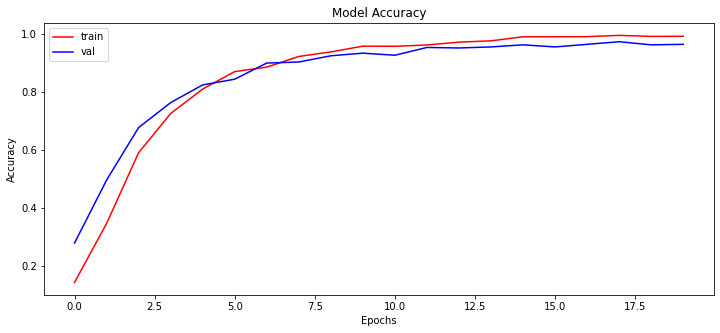

In [51]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

# Plot trainings loss history

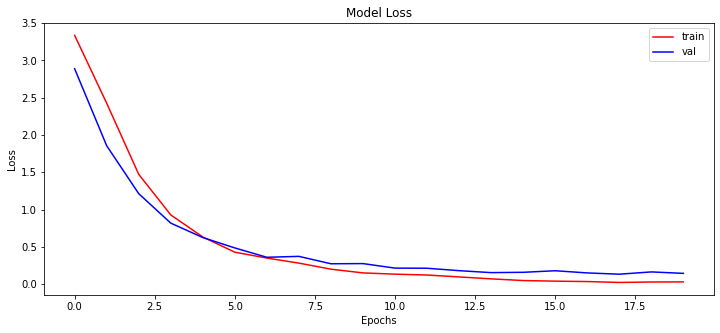

In [52]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

# Evaluation

In [53]:
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

22/22 [==============================] - 1s 27ms/step - loss: 0.1330 - accuracy: 0.9727
Test Accuracy: 97.27402925491333
